In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import folium

colorwhite='#FFFFFF'; colorblue='#003B63'; colorcyan='#45CFCC';colorbasalt='#58595B';colorslate='#92AEC5'
colorpine='#135908';colorlghgreen='#00CC66';coloryellow='#FFCB00';colororange='#E04D39'; colorair='#92AEC5'
colorspruce='#003B63'; colorenergy='#45CFCC'; colorlightblue='#D6EEFF';colorhydro='#0066B3'; colorwind='#3DADF2'
colornuclear='#EE8905';colorsolar='#FFCB00';colorbattery='#55A603';colormellow='#F7D974'; colormeadow='#9CAF2C'
colordonate='#00CC66'; colorpositive='#3B7302'; colorwarning="#BF0436"
roboto_font='fonts\Roboto-Medium.ttf'

transmission_path='Transmission_Lines.zip'
ba_path='WECC_Balancing_Authorities_1209215898356712277.zip'

tx=gpd.read_file(transmission_path)
ba=gpd.read_file(ba_path)
states=gpd.read_file('us-states.json')
target_crs = "EPSG:4326"

# Reproject each GeoDataFrame in the list
tx = tx.to_crs(target_crs)
ba = ba.to_crs(target_crs)
states = states.to_crs(target_crs)




<>:11: SyntaxWarning: invalid escape sequence '\R'
<>:11: SyntaxWarning: invalid escape sequence '\R'
C:\Users\Jake\AppData\Local\Temp\ipykernel_2024\1983560037.py:11: SyntaxWarning: invalid escape sequence '\R'
  roboto_font='fonts\Roboto-Medium.ttf'


EPSG:4326


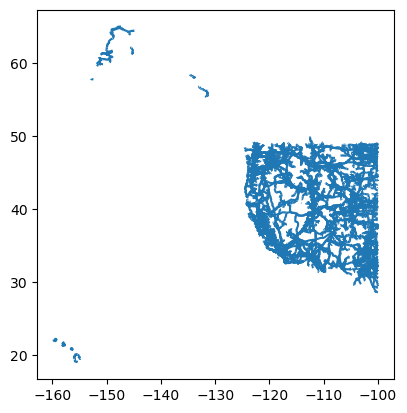

In [2]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import split
# Define the cutoff longitude
cutoff = -100  # 100W in decimal degrees (negative for west)

# Create a vertical line at 100W to split
from shapely.geometry import LineString
split_line = LineString([(-100, -90), (-100, 90)])  # vertical line spanning all latitudes

def clip_west_of_cutoff(geom):
    if geom.bounds[2] <= cutoff:
        # Entire line is west of 100W, keep it
        return geom
    elif geom.bounds[0] >= cutoff:
        # Entire line is east of 100W, discard
        return None
    else:
        # Line crosses 100W, split it
        split_result = split(geom, split_line)
        west_parts = []

        # Iterate over the geometries in the collection
        for part in split_result.geoms:
            if isinstance(part, (LineString, MultiLineString)) and part.bounds[2] <= cutoff:
                west_parts.append(part)

        if not west_parts:
            return None
        elif len(west_parts) == 1:
            return west_parts[0]
        else:
            return MultiLineString(west_parts)
        
tx2=tx.copy()
tx2['geometry'] = tx2['geometry'].apply(clip_west_of_cutoff)
tx2 = tx2.dropna(subset=['geometry'])
tx2.plot()

from shapely.geometry import box
# Check your CRS
print(tx.crs)


# Define bounding box in lon/lat
bbox_poly = box(-130, -90, -100, 50)

# Clip using the polygon
tx = gpd.clip(tx, bbox_poly)

In [3]:
import numpy as np

# Spatial join to figure out which state each BA touches
ba_states = gpd.overlay(ba, states, how="intersection")

# Keep relevant fields (assuming states has column 'name')
ba_states = ba_states[['geometry', 'BA_Name', 'name']]
# Collect all states for each BA
ba_state_groups = ba_states.groupby("BA_Name")['name'].apply(list).reset_index()

# Merge back
ba = ba.merge(ba_state_groups, on="BA_Name", how="left")

# Step 1: Compute BA areas
ba["area"] = ba.geometry.area

area_25pct = np.percentile(ba["area"], 25)

area_50pct= np.percentile(ba["area"], 50)
# Step 3: Update the assign_color function to consider size
def assign_color_with_size(state_list, area):
    # Determine if this BA is in the smallest 25%
    
    # Priority order
    if any(s in ["Washington", "Idaho"] for s in state_list):
        return colorcyan if area <= area_25pct else colorhydro if area <= area_50pct else colorblue
    elif "California" in state_list:
        return colorwarning if area <= area_25pct else colororange if area <= area_50pct else colorsolar

    elif any(s not in ["Puerto Rico", "Alaska", "Hawaii"] for s in state_list):
        return colorpine if area <= area_25pct else colorlghgreen if area <= area_50pct else colorpositive

    else:
        return colorslate

# Step 4: Apply to BA dataframe
ba["color_assignment"] = ba.apply(
    lambda row: assign_color_with_size(row["name"], row["area"]) 
                if isinstance(row["name"], list) else colorslate,
    axis=1
)


C:\Users\Jake\AppData\Local\Temp\ipykernel_2024\2480024958.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ba["area"] = ba.geometry.area


In [4]:
from shapely.geometry import Point
from folium.features import DivIcon

# m = folium.Map(location=[39, -98],  
#             #    min_lat=-20,
#             #     max_lat=80,
#             #     min_lon=-180,
#             #     max_lon=-30, # these are off for testing for ease of use but will be on for final product
#                 zoom_start=4, min_zoom=3, max_zoom=9, 
#                 # tiles=tile_url, #if we want a basemap, this is where we add it or remove, 
#                 # default= open street map
#                 #tiles=None,
#                 #other options
#                 #tiles='https://stamen-tiles-{s}.a.ssl.fastly.net/toner-lite/{z}/{x}/{y}{r}.{ext}',
#                 #  attr= attribution,
#                 # tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}',
#                 # attr='Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ',
#                 max_bounds=True,
#                 # position="absolute",
#                 # left="0%",
#                 # width="50%",s
#                 height="100%")

# folium.LayerControl().add_to(m)


# --- Folium map ---
m = folium.Map(location=[39, -98], zoom_start=4, tiles=None)

BA_group = folium.FeatureGroup('Balancing Authorities') #this enables setting all labels for VIUs to one box in feature control
basemap_group=folium.FeatureGroup('State Borders',control=False,overlay=False) 

ba_4326 = ba.to_crs(epsg=4326)

states_geojson_url = 'us-states.json'

folium.GeoJson(states_geojson_url, style_function=lambda feature: {
    'fillColor': 'lightgrey',  
    'color': 'black',  
    'weight': 1.5,  
}).add_to(basemap_group)

basemap_group.add_to(m)

# Add BA polygons all at once
folium.GeoJson(
    ba_4326.to_json(),
    style_function=lambda feature: {
        "fillColor": feature["properties"]["color_assignment"], 
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.6,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["BA_Name"],   # show BA name on hover
        aliases=["Balancing Authority:"],
    ),
).add_to(BA_group)


BA_group.add_to(m)
m.save('ba.html')

In [ ]:
from shapely.geometry import Point
from folium.features import DivIcon

t = folium.Map(location=[39, -98], zoom_start=4, tiles=None)
tx_map=tx.drop(columns=["SOURCEDATE","VAL_DATE"])

tx_map = tx_map.to_crs(epsg=4326)


states_geojson_url = 'us-states.json'


TX_group = folium.FeatureGroup('Transmission') #this enables setting all labels for VIUs to one box in feature control

folium.GeoJson(states_geojson_url, style_function=lambda feature: {
    'fillColor': 'lightgrey',  
    'color': 'black',  
    'weight': 1.5,  
}).add_to(basemap_group)

basemap_group.add_to(t)

# Add BA polygons all at once
folium.GeoJson(
    tx_map.to_json(),
    style_function=lambda feature: {
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.6,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["OWNER"],   # show BA name on hover
        aliases=["Transmission Owner:"],
    ),
).add_to(TX_group)
TX_group.add_to(t)
t.save('tx.html')

In [ ]:
#map with both

w = folium.Map(location=[39, -98], zoom_start=4, tiles=None)
basemap_group.add_to(w)
TX_group.add_to(w)
BA_group.add_to(w)
folium.LayerControl().add_to(w)

w.save('both.html')

In [7]:
# from shapely.geometry import Point
# from folium.features import DivIcon

# # Reproject to EPSG:4326 for folium
# ba_4326 = ba.to_crs(epsg=4326)

# # --- Folium map ---
# m = folium.Map(location=[39, -98], zoom_start=4, tiles="cartodbpositron")

# # Add BA polygons
# folium.GeoJson(
#     ba_4326.to_json(),
#     style_function=lambda feature: {
#         "fillColor": feature["properties"]["color_assignment"],
#         "color": "black",
#         "weight": 1,
#         "fillOpacity": 0.6,
#     }
# ).add_to(m)

# # Add text labels at representative point of each BA
# for _, row in ba_4326.iterrows():
#     if row.geometry.is_empty:
#         continue
#     rep_point = row.geometry.representative_point()
#     folium.map.Marker(
#         [rep_point.y, rep_point.x],
#         icon=DivIcon(
#             icon_size=(150, 20),
#             icon_anchor=(0, 0),
#             html=f'<div style="font-size:10pt; color:black; font-weight:bold;">{row["BA_Abrev"]}</div>',
#         )
#     ).add_to(m)

# m
